# Import Data

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import seaborn as sns
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test1'

train = os.listdir(TRAIN_DIR)
test = os.listdir(TEST_DIR)


Size of training data:  3
Size of testing data:  12500


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Metal device set to: Apple M1 Max


2021-11-24 20:22:21.108467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-24 20:22:21.108600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


2021-11-24 20:22:40.285655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 20:22:40.285967: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


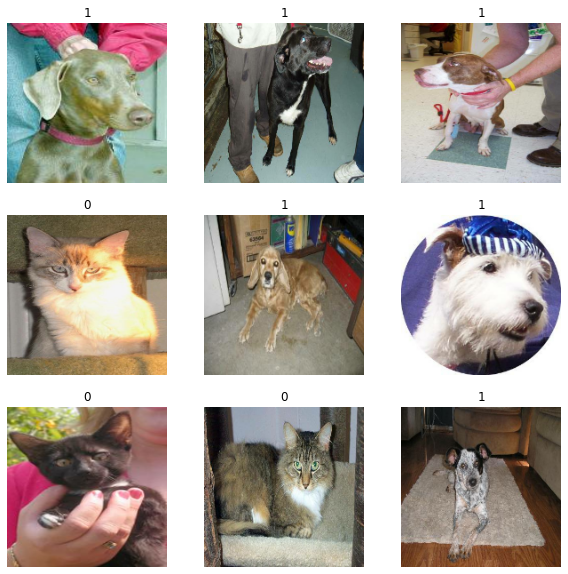

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

NotFoundError: No registered 'RngReadAndSkip' OpKernel for 'GPU' devices compatible with node {{node RngReadAndSkip}}
	.  Registered:  device='XLA_CPU_JIT'
  device='CPU'
 [Op:RngReadAndSkip]

<Figure size 720x720 with 0 Axes>

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


InvalidArgumentError: Cannot assign a device for operation model_3/sequential/random_flip/stateful_uniform_full_int/RngReadAndSkip: Could not satisfy explicit device specification '' because the node {{colocation_node model_3/sequential/random_flip/stateful_uniform_full_int/RngReadAndSkip}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RngReadAndSkip: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_3_sequential_random_flip_stateful_uniform_full_int_rngreadandskip_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model_3/sequential/random_flip/stateful_uniform_full_int/RngReadAndSkip (RngReadAndSkip) 

	 [[{{node model_3/sequential/random_flip/stateful_uniform_full_int/RngReadAndSkip}}]] [Op:__inference_train_function_11227]

In [50]:
# IMG_SIZE = 225
# def process_data(Data_DIR, image_size, isColor=True):
#     """
#     Data_DIR string: train_dir/Test_dir directory of the dataset
#     image_size int: desier image size
#     isColor bool:  decide to read the image as grayscale or color 
#     Return a new dataset of image with [[img0, label],[img1, label]....]
#     """
#     dataset = []
#     labels = []

#     for img in os.listdir(Data_DIR):
#         imgPath = os.path.join(Data_DIR,img)
#         label = img.split('.')[0]
#         if (isColor):
#             img = cv2.imread(imgPath, cv2.IMREAD_COLOR)
#         if (isColor==False):
#             img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
#         img = cv2.resize(img,(image_size, image_size))
        
#         dataset.append(np.array(img))
#         labels.append(np.array(label))
#     return dataset, labels
# data = process_data(TRAIN_DIR, IMG_SIZE, isColor=True)

# #dataset[image_index][0==image 1==label]
# #the size of image is image_size * image_size, array of int
    

# Build Models

## Logistic Regression

In [23]:
# Write code in this cell to build your Logistic Regression Model
class LogisticRegression():
    """Class for training and using a model for logistic regression"""
    
    def set_values(self, initial_params, alpha=0.01, max_iter=5000, class_of_interest=0):
        """Set the values for initial params, step size, maximum iteration, and class of interest"""
        self.params = initial_params
        self.alpha = alpha
        self.max_iter = max_iter
        self.class_of_interest = class_of_interest
    
    @staticmethod
    def _sigmoid(x):
        """Sigmoide function"""
        if x < 0:
            return 1 - 1/(1+np.exp(x))
        else:  
            return 1/(1+np.exp(-x))
    
    def predict(self, x_bar, params):
        """predict the probability of a class"""  
        
        return self._sigmoid(np.dot(params, x_bar))   

    def _compute_cost(self, input_var, output_var, params):
        """Compute the log likelihood cost"""
        cost = 0

        for x, y in zip(input_var, output_var):
            x_bar = np.array(np.insert(x, 0, 1))
            h = self.predict(x_bar, params)
            y_binary = 1 if  y == self.class_of_interest else 0 # Return 1 if xy[1] equals class of interest and 0 otherwise
            
            if h == 0:
                h = 0.0000001
            if h == 1:
                h = 0.9999999
            
            cost += y_binary * np.log(h) +(1-y_binary)*np.log(1-h)
        
        return cost

    
    def train(self, input_var, label, print_iter = 5000):
        """Train the model using batch gradient ascent"""
        
        iteration = 1
        while iteration < self.max_iter:
            if iteration % print_iter == 0:
                print(f'iteration: {iteration}')
                print(f'cost: {self._compute_cost(input_var, label, self.params)}')
                print('--------------------------------------------')
            
            for i, xy in enumerate(zip(input_var, label)):
                x_bar = np.array(np.insert(xy[0], 0, 1))
                y_hat = self.predict(x_bar, self.params)
                
                # Return 1 if xy[1] equals class of interest and 0 otherwise
                y_binary = 1 if xy[1] == self.class_of_interest else 0 
                #if its predicts correctly, y = 1
                gradient =  (y_binary - y_hat )*x_bar
                self.params += self.alpha* gradient
            
            iteration += 1
        
        return self.params

    def test(self, input_test, label_test):
        """Test the accuracy of the model using test data"""
        # Note* You can write your own approach to test, this is just one approach
        self.total_classifications = 0
        self.correct_classifications = 0
        
        for x,y in zip(input_test, label_test):
            self.total_classifications += 1
            x_bar = np.array(np.insert(x, 0, 1))
            y_hat = self.predict(x_bar, self.params)
            y_binary = 1 if y == self.class_of_interest else 0
            
            if y_hat >= 0.5 and  y_binary == 1:
                # correct classification of class_of_interest
                self.correct_classifications += 1
              
            if y_hat < 0.5 and  y_binary != 1:
                # correct classification of an other class
                self.correct_classifications += 1
                
        self.accuracy = self.correct_classifications / self.total_classifications
            
        return self.accuracy

In [26]:
alpha = 1e-2
params_0 = np.zeros(len(dataset[0]) + 1)

max_iter = 10000
cat_and_dog_regression_model = LogisticRegression() # Initialize the class
cat_and_dog_regression_model.set_values(params_0, alpha, max_iter, 0) # set initial values

params = cat_and_dog_regression_model.train(dataset, labels) # Train the model

ValueError: shapes (226,) and (151876,) not aligned: 226 (dim 0) != 151876 (dim 0)

## Result

## CNN

# Test Results